In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
%matplotlib inline


import plotly.graph_objects as go
from sklearn import preprocessing
from matplotlib import colors
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
import sys
if not sys.warnoptions:
    warnings.simplefilter('ignore')
np.random.seed(42)
import datetime
from datetime import datetime
from datetime import timedelta
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
rfm = pd.read_csv("C:/Users/HARDEEP/OneDrive/Docs/Automobile-Sales-Logistics/Data/Cleaned-Data/rfm_output.csv")

In [3]:
def business_cluster(row):
    if row['value_tier'] == 'High Value' and row['ship_bucket'] in ['Critical', 'Unreliable']:
        return 'High Value – Fulfilment Risk'
    
    if row['value_tier'] == 'High Value' and row['ship_bucket'] in ['Reliable', 'Minor Issues']:
        return 'High Value – Stable VIP'
    
    if row['value_tier'] == 'Mid Value' and row['ship_bucket'] in ['Critical', 'Unreliable']:
        return 'Mid Value – Fulfilment Risk'
    
    if row['value_tier'] == 'Mid Value' and row['ship_bucket'] in ['Reliable', 'Minor Issues']:
        return 'Mid Value – Growth Potential'
    
    if row['value_tier'] == 'Low Value' and row['ship_bucket'] in ['Critical', 'Unreliable']:
        return 'Low Value – High Risk'
    
    if row['value_tier'] == 'Low Value' and row['ship_bucket'] in ['Reliable', 'Minor Issues']:
        return 'Low Value – Stable (Upsell Test)'
    
    return 'Dormant / Lost'


# 👉 Yahan column ACTUALLY create ho raha hai
rfm['business_cluster'] = rfm.apply(business_cluster, axis=1)

# Ab yeh chalega bina error:
rfm['business_cluster'].value_counts()


business_cluster
Mid Value – Growth Potential        43
High Value – Stable VIP             21
Low Value – Stable (Upsell Test)    10
Mid Value – Fulfilment Risk          8
High Value – Fulfilment Risk         6
Low Value – High Risk                1
Name: count, dtype: int64

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# -------------------------
# Simple Business Features
# -------------------------

kmeans_features = [
    'recency_days',
    'frequency_orders',
    'monetary_sales',
    'n_unique_products',
    'shipping_reliability'
]

X = rfm[kmeans_features]


In [5]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

rfm['kmeans_cluster'] = kmeans.fit_predict(X_scaled)


In [7]:
cluster_profile = (
    rfm
    .groupby('kmeans_cluster')[kmeans_features]
    .mean()
    .round(1)
)

cluster_profile

,recency_days,frequency_orders,monetary_sales,n_unique_products,shipping_reliability
kmeans_cluster,,,,,
0,164.8,3.0,94611.6,24.2,1.0
1,68.8,3.5,113690.5,29.5,0.6
2,2.0,21.5,783576.1,91.5,0.9
3,444.3,2.1,66861.9,18.1,1.0


In [8]:
cluster_name_map = {
    0: "VIP High Spenders",
    1: "Frequent Small Buyers",
    2: "Dormant / At Risk",
    3: "Shipping Risk Buyers"
}

rfm['kmeans_label'] = rfm['kmeans_cluster'].map(cluster_name_map)

rfm['kmeans_label'].value_counts()


kmeans_label
VIP High Spenders        62
Frequent Small Buyers    14
Shipping Risk Buyers     11
Dormant / At Risk         2
Name: count, dtype: int64

In [9]:
pd.crosstab(
    rfm['business_cluster'],
    rfm['kmeans_label']
)


kmeans_label,Dormant / At Risk,Frequent Small Buyers,Shipping Risk Buyers,VIP High Spenders
business_cluster,,,,
High Value – Fulfilment Risk,0,6,0,0
High Value – Stable VIP,0,0,5,16
Low Value – High Risk,0,1,0,0
Low Value – Stable (Upsell Test),0,0,1,9
Mid Value – Fulfilment Risk,1,7,0,0
Mid Value – Growth Potential,1,0,5,37


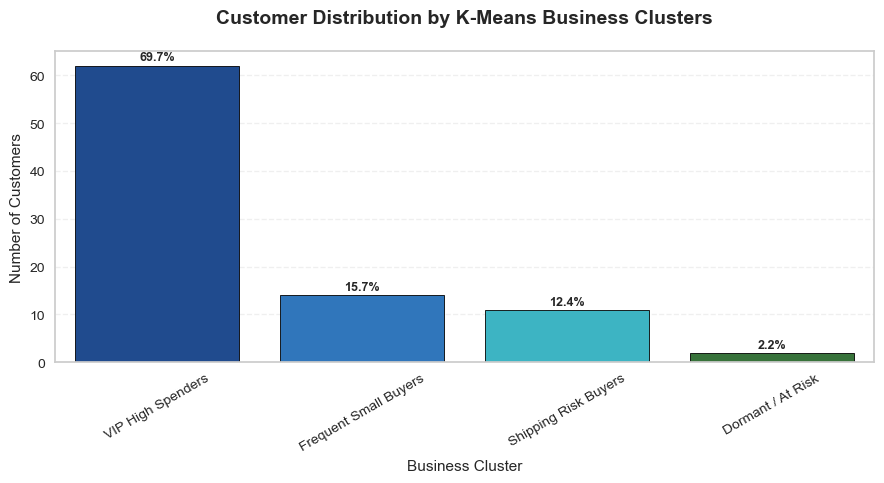

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,5))

# ✅ Premium Consulting Color Palette (Safe for Reports & Power BI)
premium_palette = [
    "#0D47A1",  # Deep Blue
    "#1976D2",  # Corporate Blue
    "#26C6DA",  # Teal
    "#2E7D32",  # Executive Green
    "#F9A825",  # Business Yellow
    "#8E24AA"   # Strategy Purple
]

ax = sns.countplot(
    data=rfm,
    x='kmeans_label',
    palette=premium_palette,
    edgecolor='black',
    linewidth=0.6
)

# ✅ Premium Title & Labels
plt.title(
    "Customer Distribution by K-Means Business Clusters",
    fontsize=14,
    fontweight='bold',
    pad=20
)

plt.xlabel("Business Cluster", fontsize=11)
plt.ylabel("Number of Customers", fontsize=11)

plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)

# ✅ Only Y-axis grid (clean corporate look)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# ✅ Percent Labels (Perfectly Aligned)
total = len(rfm)
for p in ax.patches:
    count = p.get_height()
    percent = (count / total) * 100

    ax.text(
        p.get_x() + p.get_width()/2,
        count + (total * 0.005),

        f"{percent:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight='bold'
    )

plt.tight_layout()


plt.savefig(
    "C:/Users/HARDEEP/OneDrive/Docs/Automobile-Sales-Logistics/Output/Visuals_Plots/Customer Distribution by K-Means Business Clusters.png",
    dpi=300,
    bbox_inches="tight"
)


plt.show()


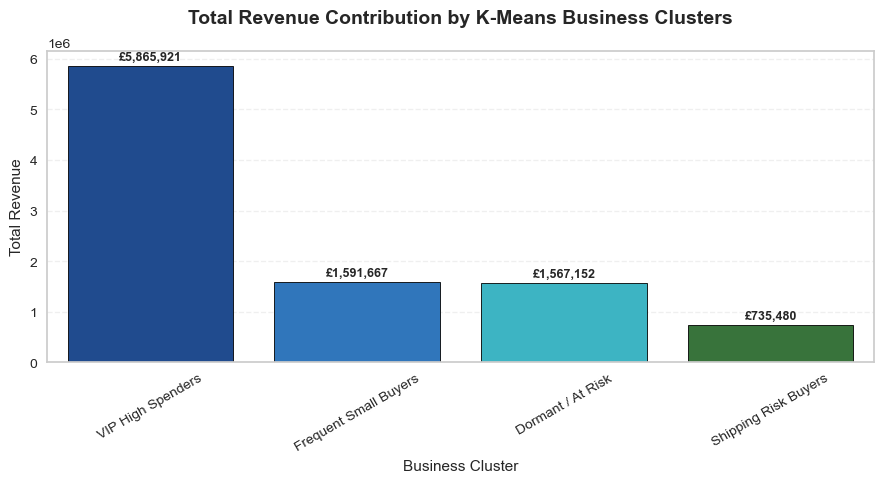

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,5))

cluster_revenue = (
    rfm.groupby('kmeans_label')['monetary_sales']
       .sum()
       .sort_values(ascending=False)
       .reset_index()
)

# ✅ Same Premium Consulting Palette (Consistency Across Dashboard)
premium_palette = [
    "#0D47A1",  # Deep Blue
    "#1976D2",  # Corporate Blue
    "#26C6DA",  # Teal
    "#2E7D32",  # Executive Green
    "#F9A825",  # Business Yellow
    "#8E24AA"   # Strategy Purple
]

ax = sns.barplot(
    data=cluster_revenue,
    x='kmeans_label',
    y='monetary_sales',
    palette=premium_palette,
    edgecolor='black',
    linewidth=0.6
)

# ✅ Premium Title & Labels
plt.title(
    "Total Revenue Contribution by K-Means Business Clusters",
    fontsize=14,
    fontweight='bold',
    pad=20
)

plt.xlabel("Business Cluster", fontsize=11)
plt.ylabel("Total Revenue", fontsize=11)

plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)

# ✅ Clean Corporate Grid
plt.grid(axis='y', linestyle='--', alpha=0.3)

# ✅ Value Labels with Comma Formatting & Spacing

for p in ax.patches:
    value = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2,
        value + (cluster_revenue['monetary_sales'].max() * 0.01),
        f"£{int(value):,}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight='bold'
    )


plt.tight_layout()


plt.savefig(
    "C:/Users/HARDEEP/OneDrive/Docs/Automobile-Sales-Logistics/Output/Visuals_Plots/Total Revenue Contribution by K-Means Business Clusters.png",
    dpi=300,
    bbox_inches="tight"
)


plt.show()


In [12]:
pd.crosstab(
    rfm['business_cluster'],
    rfm['kmeans_label'],
    normalize='index'
).round(2)


kmeans_label,Dormant / At Risk,Frequent Small Buyers,Shipping Risk Buyers,VIP High Spenders
business_cluster,,,,
High Value – Fulfilment Risk,0.00,1.00,0.00,0.00
High Value – Stable VIP,0.00,0.00,0.24,0.76
Low Value – High Risk,0.00,1.00,0.00,0.00
Low Value – Stable (Upsell Test),0.00,0.00,0.10,0.90
Mid Value – Fulfilment Risk,0.12,0.88,0.00,0.00
Mid Value – Growth Potential,0.02,0.00,0.12,0.86
